In [12]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.io.common import CParserError
import os
import matplotlib.pyplot as plt
import empyrical
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML
os.chdir('/Users/Ravi/Desktop/TSMOM/')
import statsmodels.tsa.api as smt


In [13]:
import tsmom
# from importlib import reload
# reload(tsmom)

In [14]:
# readfile
etf_table = pd.read_excel('ETFLists.xlsx', sheet_name= 'Consolidated', )

# remove etfs with NaN Avg Volume
etf_table = etf_table.loc[~etf_table['Avg Volume'].isnull(),: ]

# excel file was already sorted
sorter = 'Avg Volume'
# Number of ETFs you want to take into conisderation
n_etf = 100
top_etf_ticks = etf_table.iloc[:n_etf, 0].values

# The start and end date in consideration for analysis (currently 10 years)
yrs = 15
end_date = dt.datetime.today()
start_yr = (end_date - pd.DateOffset(years = yrs)).year
start_date = dt.datetime(start_yr, 1, 1)

In [4]:
# top_etf_panel = pd.DataFrame()
# for tick in top_etf_ticks:
#     ydr = YahooDailyReader(tick, start= start_date, end = end_date)
#     try:
#         df = ydr.read()
#         top_etf_panel[tick] = df['adjclose']
#     except requests.exceptions.TooManyRedirects:
#         pass

In [15]:
# Get the adj closing price
# top_etf_panel = get_adj_close(top_etf_ticks, start_date, end_date, 'google')
top_etf_panel = pd.read_csv('ETFPrices.csv', parse_dates=[0], index_col = [0])
top_etf_panel = top_etf_panel.loc[start_date:, :]
# Log rets and arithmatic rets
logrets = tsmom.get_rets(top_etf_panel, kind = 'log' , freq = 'd')
arthrets = tsmom.get_rets(top_etf_panel, kind = 'arth', freq= 'm')

#check cumulative performance
pfmnce = top_etf_panel.apply(lambda x: tsmom.get_eq_line(x, 
                                                         data = 'prices', 
                                                         ret_type = 'arth')
                            )
cumsum = logrets.cumsum()

In [19]:
# worst performers
mean = arthrets.mean()

wrst_pf = list(mean.nsmallest(10).index.values)
bst_pf = list(mean.nlargest(10).index.values)
print('Best performers from the list of 100 ETFs since {}\
 to {} are:'.format(arthrets.index[0].date(), arthrets.index[-1].date()))
print('\n'.join(str(i) for i in bst_pf))
print('\n\n\n')
print('Worst performers from the list of 100 ETFs since {}\
 to  {} are:'.format(arthrets.index[0].date(), arthrets.index[-1].date()))
print('\n'.join(str(i) for i in wrst_pf))

Best performers from the list of 100 ETFs since 2003-01-31 to 2018-02-28 are:
TQQQ
SVXY
UPRO
SPXL
TNA
FAS
LABU
QLD
YINN
XBI




Worst performers from the list of 100 ETFs since 2003-01-31 to  2018-02-28 are:
UVXY
TVIX
FAZ
VXX
TZA
SQQQ
VIXY
SPXS
SPXU
LABD


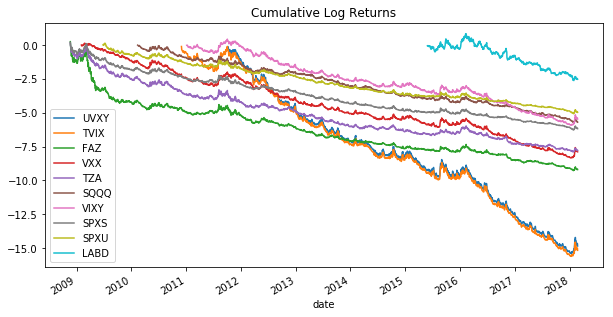

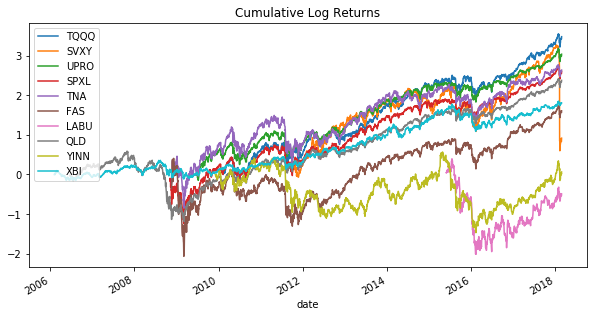

In [20]:
# Plot cumulative performances
cumsum[wrst_pf].plot(legend = True, title = 'Cumulative Log Returns', figsize= (10, 5), grid = False)
cumsum[bst_pf].plot(legend = True, title = 'Cumulative Log Returns', figsize= (10, 5))
# pfmnce.plot(legend = False, logy = True, title = 'Cumulative Returns, Log Scale', figsize= (10,5))

In [21]:
daily_cum = top_etf_panel.apply(lambda x: tsmom.get_eq_line(x, data = 'prices', dtime= 'daily'))
mnth_cum = top_etf_panel.apply(lambda x: tsmom.get_eq_line(x, data = 'prices'))
mnth_vol = top_etf_panel.apply(lambda x: tsmom.get_exante_vol(x, dtype = 'prices', com = None))

In [22]:
## 10 Largest Max Drawdowns
n = 10
drawdowns = tsmom.drawdown(arthrets, ret_type= 'arth', ret_ = 'notext')
n_large = (drawdowns.nlargest(n)).apply(lambda x : "{0:,.5%}".format(x))
n_small = drawdowns.nsmallest(n).apply(lambda x : "{0:,.2%}".format(x))
print('The {0} largest maximum drawdowns are: \n\n{1} \n\n'.format(n, n_large))
print('The {0} smallest maximum drawdowns are: \n\n{1} \n\n'.format(n, n_small))

The 10 largest maximum drawdowns are: 

TVIX    99.99998%
UVXY    99.99995%
FAZ     99.97959%
VXX     99.97592%
TZA     99.94141%
VIXY    99.79785%
SPXS    99.77531%
SQQQ    99.64143%
SPXU    99.16361%
QID     99.11257%
dtype: object 


The 10 smallest maximum drawdowns are: 

SHY     1.18%
BSV     2.54%
BND     4.19%
AGG     4.31%
GOVT    4.70%
USMV    5.28%
SPLV    5.41%
VCIT    6.09%
BKLN    7.51%
IEF     7.60%
dtype: object 




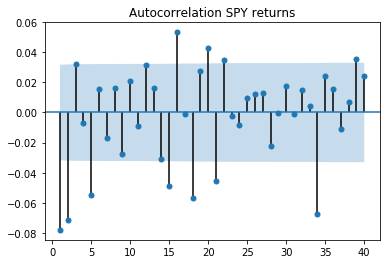

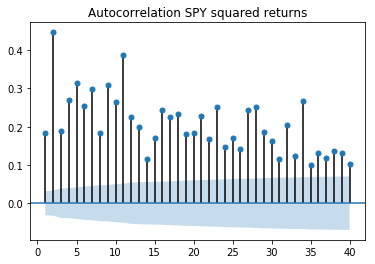

In [23]:
k = smt.graphics.plot_acf(logrets['SPY'].dropna(), 
                      lags = 40, 
                      title = 'Autocorrelation {} returns'.format('SPY'), 
                      zero = False, 
                     )

j = smt.graphics.plot_acf(logrets['SPY'].dropna() ** 2, 
                      lags = 40, 
                      title = 'Autocorrelation {} squared returns'.format('SPY'), 
                      zero = False, 
                     )


In [24]:
unlevered = tsmom.get_tsmom_port(mnth_vol, mnth_cum)
levered = tsmom.get_tsmom_port(mnth_vol, mnth_cum, flag = True, scale = 0.25)

/Users/Ravi/anaconda/lib/python3.6/tsmom.py:534: RuntimeWarning:

divide by zero encountered in double_scalars



In [25]:
unlevered.loc[:, 'Cumulative'] = (1 + unlevered.loc[:, 'TSMOM']).cumprod()
levered.loc[:, 'Cumulative VolScale'] = (1 + levered.loc[:, 'TSMOM VolScale']).cumprod()

strat = unlevered.iloc[:, 0]
strat_vol = levered.iloc[:,0]

In [26]:
def get_backtest_res(series, freq = 'monthly'):
    port_mean, port_std, port_sr = tsmom.get_stats(series, freq)
    nmonths = series.shape[0]
    if freq == 'daily':
        nmonths = series.resample('BM').last().shape[0]
    
    print('Back test period for {0} is from {1} to {2} \
with a total of {3} months \n\n'.format(series.name, 
                                        series.index[0].date().strftime('%b-%Y'), 
                                        series.index[-1].date().strftime('%b-%Y'), 
                                        nmonths))
    print(('Annualized returns for {0} \
is: {1:,.2%}\nAnnualized volatility for {0} is: {2:,.2%}\n\
Sharpe Ratio for {0} is {3:,.3f}\n\n').format(series.name, 
                                              port_mean, 
                                              port_std, 
                                              port_sr, 
                                               ))
    
get_backtest_res(strat)
get_backtest_res(strat_vol)

Back test period for TSMOM is from Jan-2004 to Feb-2018 with a total of 170 months 


Annualized returns for TSMOM is: 35.69%
Annualized volatility for TSMOM is: 25.65%
Sharpe Ratio for TSMOM is 1.392


Back test period for TSMOM VolScale is from Jan-2004 to Feb-2018 with a total of 170 months 


Annualized returns for TSMOM VolScale is: 27.89%
Annualized volatility for TSMOM VolScale is: 20.77%
Sharpe Ratio for TSMOM VolScale is 1.343




In [28]:
os.chdir('/Users/Ravi/Desktop/ETFMomentum/')
spy_prices = pd.read_csv('spy_1985.csv', 
                         index_col = [0], 
                         parse_dates= True, 
                         dtype= {'Adj Close**': np.float64}, 
                         thousands = ',')
spy_prices = spy_prices.loc[start_date + pd.DateOffset(months = 12):, 'Adj Close**']
spy_prices.name = 'SPY'

# spy_mnth_cum = tsmom.get_eq_line(spy_prices, data = 'prices', dtime = 'monthly')
# spy_mnth_cum.iloc[0] = 1


In [29]:
# spy_mnth_cum.iloc[0] = 1
spy_rets = tsmom.get_rets(spy_prices).fillna(0)
spy_rets = spy_rets.reindex(unlevered.index)
spy_mnth_cum = tsmom.get_eq_line(spy_rets)


In [30]:
spy_rets_d = tsmom.get_rets(spy_prices, freq= 'd')

spy_mean, spy_std, spy_sr = tsmom.get_stats(spy_rets_d, dtime= 'daily')

print('Back test period for {0} is from {1} to {2} \
with a total of {3} days and {4} months \n\n'.format(spy_rets_d.name, 
                                                     spy_rets.index[0].date().strftime('%b-%Y'), 
                                                     spy_rets.index[-1].date().strftime('%b-%Y'), 
                                                     np.busday_count(spy_rets.index[0], spy_rets.index[-1]),
                                                     spy_rets.shape[0], 
                                                     ))
print(('Annualized Mean for {3} \
is: {0:,.2%}\nAnnualized volatility for {3} is: {1:,.2%}\n\
Sharpe Ratio for {3} is {2:,.3f}').format(spy_mean, 
                                          spy_std, 
                                          spy_sr, 
                                          spy_rets.name))

Back test period for SPY is from Jan-2004 to Feb-2018 with a total of 3673 days and 170 months 


Annualized Mean for SPY is: 8.13%
Annualized volatility for SPY is: 18.44%
Sharpe Ratio for SPY is 0.441


In [31]:
unlevered.loc[:, 'SPY'] = spy_mnth_cum
levered.loc[:, 'SPY'] = spy_mnth_cum
# unlevered.iloc[0, -2:] = 1
# levered.iloc[0, -2:] = 1


Text(0.5,1,'Monthly Returns Scatter Plot')

Text(0.5,0,'SPY Returns %')

Text(0,0.5,'TSMOM VolScale Returns %')

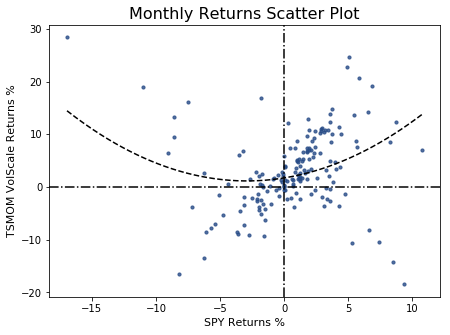

In [33]:
x = spy_rets
y = strat
from scipy.interpolate import UnivariateSpline
ax, fig = plt.subplots(figsize = (7, 5))
plt.scatter(x * 100, 
            y * 100, 
            c = '#284c87', 
            marker= 'o', 
            s = 10,
            alpha = 0.8)
model = np.polyfit(x = x * 100, 
                   y = y * 100, 
                   deg = 2)
f = np.poly1d(model)

xs = np.linspace(np.min(x) * 100, 
                 np.max(x) * 100, 
                 250)
ys = f(xs)
plt.plot(xs, ys, ls = '--', c = 'black')

plt.axhline(y = 0, c = 'k', ls = '-.')
plt.axvline(x = 0, c = 'k', ls = '-.')
plt.title('Monthly Returns Scatter Plot', 
          dict(fontsize = 16))
plt.xlabel('SPY Returns %', 
          dict(fontsize = 11, 
                color = 'k'))
plt.ylabel('TSMOM VolScale Returns %', 
           dict(fontsize = 11, 
                color = 'k'))

In [46]:
ts_idx = levered.index
init_cap = 100000
trace_10 = Scatter(x = ts_idx,
                   y = unlevered.Cumulative * init_cap,
                   visible = True, 
                   name = 'Unlevered TSMOM',
                   yaxis = 'y2',
                   line = dict(dash = 'line',
                               color = 'black', 
                               width = 3)
                 )
trace_20 = Scatter(x = ts_idx,
                   y = unlevered.Leverage,
                   visible = True,

                   name = 'Leverage',
                   line = dict(dash = 'dot',
                               color = 'grey', 
                               width = 0.8, 
                               )
                 )
                  
trace_30 =  Scatter(x = ts_idx,
                    y = unlevered.SPY * init_cap,
                    visible = True,
                    name = 'SPY',
                    yaxis = 'y2',
                    line = dict(dash = 'line', 
                                color = 'blue', 
                                width = 3)    
                   )

trace_11 = Scatter(x = ts_idx,
                   y = (levered['Cumulative VolScale'] * init_cap),
                   visible = False,
                   name = 'Levered TSMOM',
                   yaxis = 'y2',
                   line = dict(dash = 'line',
                               color = 'black', 
                               width = 3)
                 )
trace_12 = Scatter(x = ts_idx,
                   y = (levered.Leverage),
                   visible = False,
                   name = 'Leverage',
                   line = dict(dash = 'dot',
                               color = 'grey', 
                               width = 0.8),
                 )
trace_13 = Scatter(x = ts_idx,
                   y = (levered.SPY) * init_cap,
                   visible = False,
                   name = 'SPY',
                   yaxis = 'y2',
                   line = dict(dash = 'line',
                               color = 'blue', 
                               width = 3,
                              )
                  )
data_ttl = [trace_10, trace_20, trace_30, trace_11, trace_12, trace_13]
updatemenus = list([dict(#type="buttons", 
                         active= 0, 
                         
                         buttons=list([dict(label = 'Unlevered',  
                                            method = 'update', 
                                            args = [{'visible': [True, True, True, False, False, False]},]),
                       
                                       dict(label = 'Levered', 
                                            method = 'update', 
                                            args = [{'visible': [False, False, False, True, True, True]},]), 
                                       
                                      ]),  
                         x = 0.15,
                         y = 1.2
                        ),
                   ], 
                   
                  )

lay = Layout(title = 'TSMOM scaled for volatility',
             legend = dict(x = 0.75, y = 1.22),

             xaxis = dict(title = 'Dates', 
                          showgrid = True, 
                          showticklabels = True,
                          linecolor = 'black',
                          tickformat = '%b %Y',
                          hoverformat = '%b %Y'
                         ),
             
              yaxis = dict(title = 'Leverage', 
                          showgrid = False,
                          showticklabels = True,
                          linecolor = 'black',
                            side = 'left',
                          range = [0, 6],
                           
                          ),
             yaxis2 = dict(title = 'Cumulative Returns', 
                          showgrid = False,
                          showticklabels = True,
                          linecolor = 'black',
                          range = [4.78, 7.1],
                          nticks = 5,
                          type = 'log',
                           overlaying = 'y',
                           side = 'right'
                          ),
             
             paper_bgcolor = 'white',
             plot_bgcolor = 'white',
             autosize = False,
             height = 450,
             width = 750,
             showlegend = True,
             updatemenus = updatemenus,

             shapes = [
                 {
                     'type' : 'line',
                     'xref' : 'paper',
                     'x0' : 0,
                     'y0' : init_cap,
                     'x1' : 1,
                     'y1' : init_cap,
                     'line' : {
                         
                         'color': 'black',
                         'width': 1,
                         'dash': 'dash'
                             },
                 },

                     {
                      
                      'x0':'2007-08-01', 
                      'x1':'2009-06-01', 
                      'yref': 'paper',
                      'y0':0,
                      'y1':1,
                      'fillcolor':'rgba(30,30,30,0.3)',  
                      'opacity':.2, 
                      'line' : {'width': 0
                               },
                      },
             ]
            )
annot = []

annot.extend([dict(#xref = 'paper',
                  yref = 'paper',
                  x = '2010-05-27',
                  y= 0.98,
                  xanchor ='right', 
                  yanchor='right',
                  text= 'Global Financial Crisis',
                  font=dict(family='<b>Arial<b>',
                            size= 12, 
                            color= 'black',
                           ),
                  showarrow=False), 

             ]
            )

lay['annotations'] = annot
fig_ttl = Figure(data = data_ttl, layout = lay)
iplot(fig_ttl, show_link = False, filename= '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFPort.html')

In [36]:
tsmom.get_monthly_heatmap(strat, 
                          plt_type= 'iplot',
                          cmap = 'RdYlGn', 
                          yr_from='2003',
                          width = 600,
                          height = 500,
                          filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFHeatMap.html',
                          vmin = -50,
                          colors = ['black', 'white']
                         )
tsmom.get_monthly_heatmap(strat_vol, 
                          cmap = 'RdYlGn', 
                          yr_from = '2003', 
                          plt_type = 'iplot', 
                          filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFHeatMapVol.html',
                          vmax = 300,
                          width = 600,
                          height = 500,
                          vmin = -50,
                          colors = ['black', 'black']
                          )

# get_monthly_hist(strat)
# get_monthly_hist(strat_vol)

# tsmom.underwater(strat, spy_rets,
#                  plt_type= 'plot', 
#                  filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFUnderwater.html', 
#                  width = 550, 
#                  height = 320, 
#                  range = [-65, 0])
# tsmom.underwater(strat_vol, spy_rets,
#                  plt_type= 'plot', 
#                  filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFVolUnderwater.html', 
#                  width = 550, 
#                  height = 320, 
#                  range = [-65, 0])
# tsmom.underwater(spy_rets, 
#                  plt_type= 'plot', 
#                  filename = 'SPYUnderwater.html', 
#                  width = 550, 
#                  height = 320)

iplot(tsmom.get_ann_ret_plot(strat, 
                            width = 500, 
                            height = 500, 
                            x2range= [-40, 110]), 
     show_link = False, 
     filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFAnnRets.html')
iplot(tsmom.get_ann_ret_plot(strat_vol, 
                            width = 500, 
                            height = 500, 
                            x2range= [-40, 110]), 
     show_link = False, 
     filename = '/Users/Ravi/Desktop/Git/india-famafrench/docs/_static/ETFVolAnnRets.html')
# plot(tsmom.get_ann_ret_plot(spy_rets_d, 
#                             width = 650, 
#                             height = 700, 
#                             dtime= 'daily', 
#                             x2range= [-40, 110]), 
#      show_link = False, 
#      filename = 'SPY.html')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [42]:
# t_yrs = spy_rets_d.index.groupby(spy_rets_d.index.year)
# std = {}
# av = {}
# for key, val in t_yrs.items():
#     std[key] = spy_rets_d.loc[val].std() * np.sqrt(252)
#     av[key] = spy_rets_d.loc[val].std() * 252
# pd.Series(std)

In [37]:
stats = pd.concat([tsmom.get_perf_att(strat, spy_rets), 
           tsmom.get_perf_att(strat_vol, spy_rets), 
           tsmom.get_perf_att(spy_rets_d, spy_rets_d, freq='daily')], axis = 1)
stats

,TSMOM,TSMOM VolScale,SPY
Alpha,0.316,0.231,0
Annualized_Mean,0.36,0.28,0.08
Annualized_Volatility,0.256,0.208,0.184
Beta,0.261,0.432,1
Calmar Ratio,0.834,1.04,0.117
Max Drawdown,45.39%,27.91%,56.78%
Sharpe Ratio,1.392,1.343,0.441
Sortino Ratio,2.573,2.177,-3.647


In [43]:
# reload(tsmom)
tsmom.underwater(strat, spy_rets, width = 800)
tsmom.underwater(strat_vol, spy_rets, width = 800)

In [21]:
periods = tsmom.pf.interesting_periods.PERIODS
p_df = pd.DataFrame(periods)
p_df.index = ['From', 'To']
p_df = p_df.transpose()
p_df = p_df.applymap(lambda x: x.to_period(freq = 'd'))
p_df

,From,To
Dotcom,2000-03-10,2000-09-10
Lehmann,2008-08-01,2008-10-01
9/11,2001-09-11,2001-10-11
US downgrade/European Debt Crisis,2011-08-05,2011-09-05
Fukushima,2011-03-16,2011-04-16
US Housing,2003-01-08,2003-02-08
EZB IR Event,2012-09-10,2012-10-10
Aug07,2007-08-01,2007-09-01
Mar08,2008-03-01,2008-04-01
Sept08,2008-09-01,2008-10-01
